# 量子神经网络的表达能力

<em>Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.</em>

## 概览

在量子机器学习中，量子神经网络的**表达能力**是决定量子机器学习任务能否成功的关键因素。一般来说，量子神经网络拟设的表达能力越强，量子机器学习能够搜索到全局最优解的可能性就越大。本教程首先介绍量子神经网络表达能力的基本概念，随后将在量桨中展示如何通过布洛赫球感受不同拟设表达能力的差别。最后介绍一种定量分析量子神经网络表达能力的方法，并评估量桨提供的量子神经网络模板在不同深度下的表达能力。

## 基本概念

我们先来回顾一下量子机器学习算法的基本流程。在量子机器学习中，我们往往设计一个损失函数 $\mathcal{L}$，并通过优化一个酉变换 $U$ 使得损失函数最小化：

$$
\min_U\mathcal{L}(U)=\min_U \text{tr}[HU\rho_{in}U^\dagger],\tag{1}
$$

算法背后的数学原理保证当我们遍历完所有可能的酉变换后，损失函数能取到的最小值就对应于我们问题的解。而在实际操作中，我们采用量子神经网络将酉变换参数化：

$$
U=U(\vec{\theta})=U_D(\vec{\theta}_D)\dots U_1(\vec{\theta}_1),\tag{2}
$$

其中每个 $U_j(\vec{\theta}_j),j\in[1,D]$ 代表一层量子神经网络，$\vec{\theta}_j$ 代表该层对应的参数。此时，通过调整量子神经网络中的参数 $\vec{\theta}$，我们就可以进行对酉变换 $U$ 的优化，进而最小化损失函数 $\mathcal{L}$：

$$
\min_{\vec{\theta}}\mathcal{L}(\vec{\theta})=\min_{\vec{\theta}} \text{tr}[HU(\vec{\theta})\rho_{in}U(\vec{\theta})^\dagger].\tag{3}
$$

然而，细心的读者此时可能已经发现了量子神经网络的一个不足：对于一个给定的神经网络拟设，**遍历所有的参数并不一定可以保证遍历所有的酉变换**。作为一个简单的例子，如果我们只允许使用一个 $R_Y$ 旋转门作为单比特量子神经网络 $U(\theta)=R_Y(\theta)$，显然（除去全局相位）$U(\theta)$ 不能表示任何矩阵元含虚部的复酉矩阵。而当允许使用 $R_Y$ 和 $R_Z$ 旋转门时，如果我们搭建量子神经网络为 $U(\vec{\theta})=R_Z(\theta_1)R_Y(\theta_2)R_Z(\theta_3)$，$U(\vec{\theta})$ （除去全局相位）将能够表示所有的单比特酉矩阵 [1]。

如果我们将神经网络的表达能力定义为**在遍历电路参数 $\vec{\theta}$ 时电路能够表达的酉变换的多少**，那么，一个表达能力强的量子神经网络将更有可能包含那些使得损失函数 $\mathcal{L}$ 取到全局最小值的酉变换；相反地，如果一个量子神经网络 $U_{weak}$ 的表达能力太弱以至于不包含任何能将损失函数最小化的酉变换，那么基于优化 $U_{weak}$ 的量子机器学习任务就很可能会失败。

接下来我们基于量桨，通过观察单量子比特酉门遍历布洛赫球的能力直观地感受量子神经网络的表达能力。

## 直观感受表达能力：遍历布洛赫球

对于单量子比特的简单情况，我们可以直接观察量子神经网络如何将固定输入遍历布洛赫球表面。对于一个给定的神经网络拟设 $U(\vec{\theta})$，由于网络的输入往往是固定的（不妨设为 $|0\rangle$），通过均匀地采样神经网络参数 $\vec{\theta}$，神经网络的输出态 $U(\vec{\theta})|0\rangle$ 将散落在布洛赫球表面。显然，如果输出态在球面分布地越广越均匀，那么神经网络拟设 $U$ 的表达能力也就越强，包含损失函数全局最优的可能性也就越大。

为在量桨实现这一功能，首先引入必要的包：

In [1]:
import numpy as np
import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz.circuit import Circuit
from paddle_quantum.visual import plot_state_in_bloch_sphere

/home/zl/miniconda3/envs/pq/lib/python3.8/site-packages/openfermion/hamiltonians/hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
/home/zl/miniconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/home/zl/miniconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in 

首先，我们只允许使用一个 $R_Y$ 旋转门作为单比特量子神经网络 $U(\theta)=R_Y(\theta)$。通过在 $[0,2\pi]$ 均匀采样参数 $\theta$ 并将 $U(\theta)$ 作用在固定输入 $|0\rangle$ 上，我们便得到量子神经网络 $U(\theta)$ 的输出分布。通过量桨内置的 plot_bloch_sphere_from_input 函数，我们可以直接观察 $U(\theta)|0\rangle$ 在布洛赫球面上的分布：

In [2]:
num_qubit = 1      # 设定量子比特数
num_sample = 2000  # 设定采样次数
outputs_y = list()   # 储存采样电路输出

for _ in range(num_sample):
    # 初始化量子神经网络
    pq.set_backend('density_matrix')
    cir = Circuit(num_qubit)
    # 作用 Ry 旋转门，旋转角度随机
    cir.ry(0)
    # 输出态的密度矩阵
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_y.append(rho)
    
# 量桨内置的 plot_bloch_sphere_from_input 函数
# plot_state_in_bloch_sphere(outputs_y, save_gif=True, filename='figures/bloch_y.gif')

/home/zl/miniconda3/envs/pq/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


![bloch_y.gif](./figures/expressibility-fig-bloch_y.gif)

可见，量子神经网络 $U(\theta)=R_Y(\theta)$ 的输出只能分布于布洛赫球面上的一个圆环（尽管在圆环上的分布是均匀的）。类似地，我们考虑包含两个参数的神经网络 $U(\vec{\theta})=R_Y(\theta_1)R_Z(\theta_2)$ 和 三个参数的神经网络 $U(\vec{\theta})=R_Y(\theta_1)R_Z(\theta_2)R_Y(\theta_3)$ 的输出分布：

In [3]:
outputs_yz = list()   # 储存采样电路输出
for _ in range(num_sample):
    # 初始化量子神经网络
    cir = Circuit(num_qubit)
    # 作用 Ry 和 Rz 旋转门，旋转角度随机
    cir.ry(0)
    cir.rz(0)
    # 输出态的密度矩阵
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_yz.append(rho)

# plot_state_in_bloch_sphere(outputs_yz, save_gif=True, filename='figures/bloch_yz.gif')


outputs_yzy = list()   # 储存采样电路输出
for _ in range(num_sample):
    # 初始化量子神经网络
    cir = Circuit(num_qubit)
    # 作用 Ry,Rz,Ry 旋转门，旋转角度随机
    cir.ry(0)
    cir.rz(0)
    cir.ry(0)
    # 输出态的密度矩阵
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_yzy.append(rho)
    
# plot_state_in_bloch_sphere(outputs_yzy, save_gif=True, filename='figures/bloch_yzy.gif')

![bloch_yz.gif](./figures/expressibility-fig-bloch_yz.gif)

![bloch_yzy.gif](./figures/expressibility-fig-bloch_yzy.gif)

可见，神经网络 $U(\vec{\theta})=R_Y(\theta_1)R_Z(\theta_2)$ 的输出可以分布在整个布洛赫球表面了，虽然在两级（$|0\rangle$ 和 $|1\rangle$）附近的分布会更加密集；而神经网络 $U(\vec{\theta})=R_Y(\theta_1)R_Z(\theta_2)R_Y(\theta_3)$ 的输出在球面的分布是比较均匀的。

在单量子比特的低维情形下我们可以借助布洛赫球定性观察量子神经网络的表达能力。而在一般的多量子比特应用中，我们必须借助统计数学的工具对表达能力定量分析。接下来我们将引入量子态之间保真度分布的 K-L 散度作为量化神经网络的表达能力的指标，并计算一种常见拟设的表达能力。

## 定量分析表达能力：K-L 散度

### 保真度分布与 K-L 散度

在文献 [2] 中，作者提出了基于神经网络输出态之间的保真度概率分布的表达能力量化方法。对任意量子神经网络 $U(\vec{\theta})$，采样两次神经网络参数（设为 $\vec{\phi}$ 和 $\vec{\psi}$），则两个量子电路输出态之间的保真度 $F=|\langle0|U(\vec{\phi})^\dagger U(\vec{\psi})|0\rangle|^2$ 服从某个概率分布：
$$
F\sim{P}(f).\tag{4}
$$
文献 [2] 指出，量子神经网络 $U$ 能够均匀地分布在所有酉矩阵上时（此时称 $U$ 服从哈尔分布），保真度的概率分布 $P_\text{Haar}(f)$ 满足
$$
P_\text{Haar}(f)=(2^{n}-1)(1-f)^{2^n-2}.\tag{5}
$$

量桨提供了直接从哈尔分布采样酉矩阵的函数。观察哈尔分布酉矩阵输出的量子态保真度服从的概率分布：

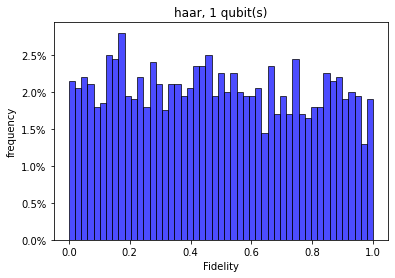

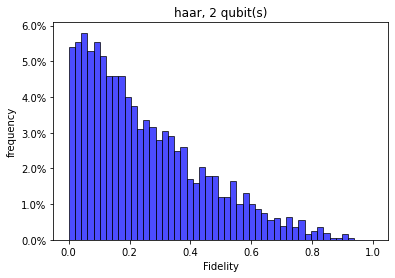

In [4]:
from paddle_quantum.linalg import haar_unitary
from paddle_quantum.qinfo import state_fidelity
from paddle_quantum.state.common import to_state
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import integrate

# 定义绘制直方图的函数
def plot_hist(data, num_bin, title_str):
    def to_percent(y, position):
        return str(np.around(y*100, decimals=2)) + '%'
    plt.hist(data, weights=[1./len(data)]*len(data), bins=np.linspace(0, 1, num=num_bin), facecolor="blue", edgecolor="black", alpha=0.7)
    plt.xlabel("Fidelity")
    plt.ylabel("frequency")
    plt.title(title_str)
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()
    
    
# 定义计算哈尔采样输出保真度分布的函数
def p_F_haar(n, s, b=50, draw=False):
    f_list = list()
    # 开始采样
    for i in range(s):
        # 采样第一个酉变换
        u1 = haar_unitary(n)
        # 输入 |0> 时酉变换的输出
        phi1 = u1[:,0]
        rho1 = to_state(np.outer(phi1, phi1.conj()))
        # 采样第二个酉变换
        u2 = haar_unitary(n)
        phi2 = u2[:,0]
        # 输入 |0> 时酉变换的输出
        rho2 = to_state(np.outer(phi2, phi2.conj()))
        # 计算两个采样输出之间的保真度
        f_list.append(state_fidelity(rho1, rho2)**2)
    f_list = np.array(f_list)
    # 绘制概率分布图
    if draw:
        title_str = "haar, %d qubit(s)" % num_qubit
        plot_hist(f_list, b, title_str)
    sample_distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)
    # 根据公式计算概率分布函数的理论值，用于后期计算 K-L 散度
    theory_distribution = np.zeros_like(sample_distribution)
    for index in range(len(theory_distribution)):
        def p_continues(f):
            return (2 ** n - 1) * (1 - f) ** (2 ** n - 2)
        lower = 1/b*index
        upper = lower + 1/b
        theory_distribution[index], _ = integrate.quad(p_continues,lower,upper)
    return sample_distribution, theory_distribution


num_qubit = 1
p_haar_1qubit, theory_haar_1qubit = p_F_haar(num_qubit, num_sample, draw=True)
num_qubit = 2
p_haar_2qubit, theory_haar_2qubit = p_F_haar(num_qubit, num_sample, draw=True)

可见保真度分布大致服从 $P_\text{Haar}$。类似地，我们也能计算之前定义的单比特量子神经网络 $R_Y(\theta)$，$R_Y(\theta_1)R_Z(\theta_2)$ 和 $R_Y(\theta_1)R_Z(\theta_2)R_Y(\theta_3)$ 输出的保真度概率分布：

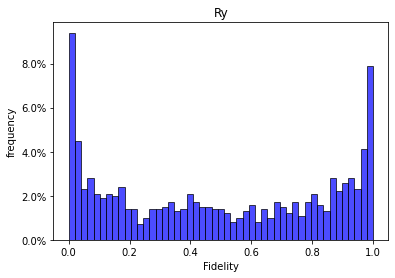

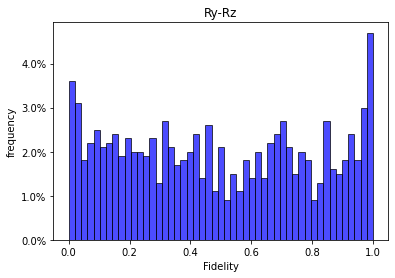

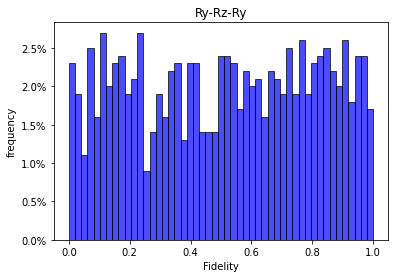

In [5]:
# 定义计算量子神经网络输出保真度分布的函数
def p_F_qnn(n, s, g, b=50, draw=False):
    f_list = list()
    rho_sample = outputs_y
    title_str = "Ry"
    if g == 2:
        rho_sample = outputs_yz
        title_str = "Ry-Rz"
    elif g == 3:
        rho_sample = outputs_yzy
        title_str = "Ry-Rz-Ry"
    # 使用之前采样的数据计算保真度分布
    for index in range(int(s / 2)):
        rho1 = rho_sample[index]
        rho2 = rho_sample[index+int(num_sample / 2)]
        f_list.append(state_fidelity(rho1, rho2)**2)
    f_list = np.array(f_list)
    # 绘制概率分布图
    if draw:
        plot_hist(f_list, b, title_str)
    distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)
    return distribution
    
    
num_qubit = 1
p_y = p_F_qnn(num_qubit, num_sample, 1, draw=True)
p_yz = p_F_qnn(num_qubit, num_sample, 2, draw=True)
p_yzy = p_F_qnn(num_qubit, num_sample, 3, draw=True)

可见，$R_Y-R_Z-R_Y$ 门组成的神经网络的输出保真度分布与均匀酉矩阵的表现最为接近。统计数学中的 K-L 散度（也称相对熵）可以衡量两个概率分布之间的差异。两个离散概率分布 $P,Q$ 之间的 K-L 散度定义为
$$
D_{KL}(P||Q)=\sum_jP(j)\ln\frac{P(j)}{Q(j)}.\tag{6}
$$
如果将量子神经网络输出的保真度分布记为 $P_\text{QNN}(f)$，则量子神经网络的表达能力定义为 $P_\text{QNN}(f)$ 和 $P_\text{Haar}(f)$ 之间的 K-L 散度 [2]：
$$
\text{Expr}_\text{QNN}=D_{KL}(P_\text{QNN}(f)||P_\text{Haar}(f)).\tag{7}
$$
因此，当 $P_\text{QNN}(f)$ 越接近 $P_\text{Haar}(f)$ 时，$\text{Expr}$ 将越小（越趋近于 0），量子神经网络的表达能力也就越强；反之，$\text{Expr}$ 越大，量子神经网络的表达能力也就越弱。

我们可以根据该定义直接计算单比特量子神经网络 $R_Y(\theta)$，$R_Y(\theta_1)R_Z(\theta_2)$ 和 $R_Y(\theta_1)R_Z(\theta_2)R_Y(\theta_3)$ 的表达能力：

In [6]:
from scipy.stats import entropy
# 使用 scipy 的 entropy 函数计算相对熵（即 K-L 散度）
expr_y = entropy(p_y, theory_haar_1qubit)
expr_yz = entropy(p_yz, theory_haar_1qubit)
expr_yzy = entropy(p_yzy, theory_haar_1qubit)
print("Ry，Ry-Rz，和 Ry-Rz-Rz 神经网络的表达能力分别为 %.2f，%.2f，和 %.2f。" %(expr_y, expr_yz, expr_yzy))

Ry，Ry-Rz，和 Ry-Rz-Rz 神经网络的表达能力分别为 0.19，0.05，和 0.02。


###   评估量子神经网络拟设的表达能力

现在，我们拥有了定量研究任何量子神经网络拟设表达能力的工具——K-L 散度。作为一个实际应用，我们来探究量桨内置拟设 complex_entangled_layer 的表达能力随电路深度的变化。这里我们设置电路的宽度为 4-qubit。

哈尔采样输出的保真度服从分布：


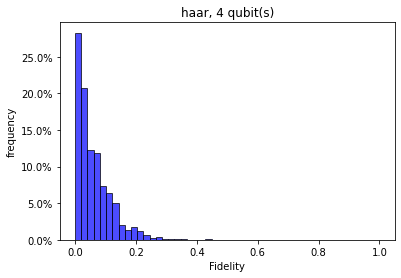

正在采样深度为 1 的电路...
   采样第 0 个样本...
   采样第 400 个样本...
   采样第 800 个样本...
   采样第 1200 个样本...
   采样第 1600 个样本...
   采样完毕


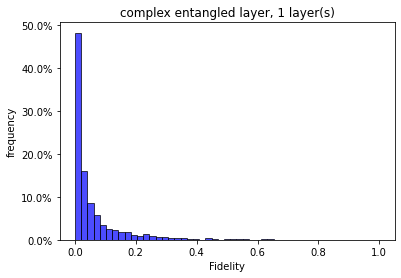

正在采样深度为 2 的电路...
   采样第 0 个样本...
   采样第 400 个样本...
   采样第 800 个样本...
   采样第 1200 个样本...
   采样第 1600 个样本...
   采样完毕


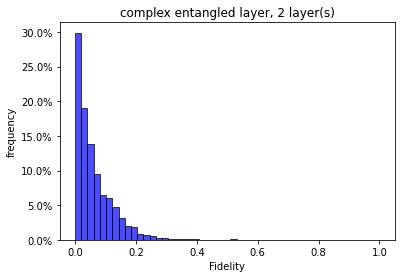

正在采样深度为 3 的电路...
   采样第 0 个样本...
   采样第 400 个样本...
   采样第 800 个样本...
   采样第 1200 个样本...
   采样第 1600 个样本...
   采样完毕


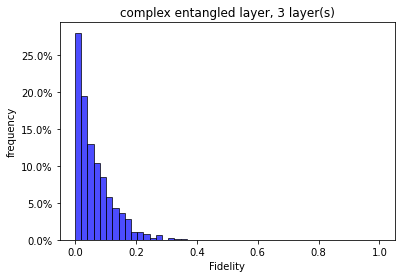

深度为 1,2,3 的神经网络的表达能力分别为 [0.2429 0.011  0.01  ]


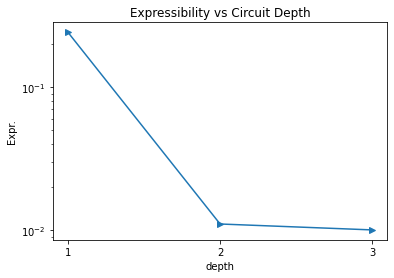

In [7]:
# 定义计算保真度分布的函数
def p_F_cel(n, d, s, b=50, draw=False):
    pq.set_backend('state_vector')
    f_list = list()
    for index in range(int(s / 2)):
        if 2 * index % 400 == 0:
            print("   采样第 %d 个样本..." % (2 * index))
        cir1 = Circuit(n)
        # 作用 complex_entangled_layer 层
        cir1.complex_entangled_layer('full', d)
        # 输出态的态矢量
        rho1 = cir1(pq.state.zero_state(n))
        
        cir2 = Circuit(n)
        # 作用 complex_entangled_layer 层
        cir2.complex_entangled_layer('full', d)
        # 输出态的态矢量
        rho2 = cir2(pq.state.zero_state(n))
        
        # 计算保真度
        f_list.append(abs(np.inner(rho1.data.numpy(), rho2.data.numpy().conj())**2))
                      
    print("   采样完毕")
    f_list = np.array(f_list)
    # 绘制概率分布图
    if draw:
        title_str = "complex entangled layer, %d layer(s)" % d
        plot_hist(f_list, b, title_str)
    distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)
    return distribution


# 设置电路宽度和最大深度
num_qubit = 4
max_depth = 3
# 计算哈尔采样对应的保真度分布
print("哈尔采样输出的保真度服从分布：")
p_haar_4qubit, theory_haar_4qubit = p_F_haar(num_qubit, num_sample, draw=True)
Expr_cel = list()
# 计算不同深度的神经网络的表达能力
for DEPTH in range(1, max_depth + 1):
    print("正在采样深度为 %d 的电路..." % DEPTH)
    p_cel = p_F_cel(num_qubit, DEPTH, num_sample, draw=True)
    expr = entropy(p_cel, theory_haar_4qubit)
    Expr_cel.append(expr)
# 比较不同深度的神经网络的表达能力
print("深度为 1,2,3 的神经网络的表达能力分别为", np.around(Expr_cel, decimals=4))
plt.plot(range(1, max_depth + 1), Expr_cel, marker='>')
plt.xlabel("depth")
plt.yscale('log')
plt.ylabel("Expr.")
plt.xticks(range(1, max_depth + 1))
plt.title("Expressibility vs Circuit Depth")
plt.show()

可见随着电路深度的增加，量子神经网络的表达能力也在逐渐增强。感兴趣的读者不妨自己动手尝试一下其他量桨内置拟设的表达能力计算，以及比较不同拟设之间表达能力的差别。

_______

## 参考文献

[1] Nielsen, Michael A., and Isaac L. Chuang. "Quantum Computation and Quantum Information." Cambridge University Press, 2010.

[2] Sim, Sukin, Peter D. Johnson, and Alán Aspuru‐Guzik. "Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum‐classical algorithms." [Advanced Quantum Technologies 2.12 (2019): 1900070](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.201900070).